In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import matplotlib as mpl

mpl.rcParams["font.size"] = 18
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
#functions are mostly copied from the lattice_2d.ipynb as only slight modification are necessary for working in 3d

In [2]:
def draw_graph(adj_list, positions, edges=True, node_size=100, save=False, file_name=""):
    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*positions.T, s=node_size) #.T-> shape=(3, num_nodes), *-> 3 seperate lists with num_nodes elements each
    if edges:
        for edge in edge_coordinates: #edge shape = (2, 3)
            ax.plot(*edge.T, c="dimgrey", alpha=0.5)
    if save:
        fig.savefig(file_name, dpi=300, bbox_inches="tight")

In [3]:
#cf. rotateLattice() in 2d
def rotX(vec, alpha_x):
    R_x = np.array([[1, 0, 0],
                   [0, np.cos(alpha_x), -np.sin(alpha_x)],
                   [0, np.sin(alpha_x), np.cos(alpha_x)]])
    return R_x@vec

def rotY(vec, alpha_y):
    R_y = np.array([[np.cos(alpha_y), 0, -np.sin(alpha_y)],
                   [0, 1, 0],
                   [np.sin(alpha_y), 0, np.cos(alpha_y)]])
    return R_y@vec
    
def rotZ(vec, alpha_z):
    R_z = np.array([[np.cos(alpha_z), -np.sin(alpha_z), 0],
                 [np.sin(alpha_z), np.cos(alpha_z), 0],
                 [0, 0, 1]])
    return R_z@vec

def rotateLattice(pos, alpha, beta, gamma):
    return np.array([rotZ(rotY(rotX(p, alpha), beta), gamma) for p in pos])

In [4]:
def addShiftedCenterNodes(nx, ny, nz, shift_vec, transform, pos, num_nodes):
    ind_pos_c = np.array(np.meshgrid(np.arange(0, nx), np.arange(0, ny), np.arange(0, nz)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
    pos_c = np.array([(transform@p_c + shift_vec) for p_c in ind_pos_c])
    num_nodes += len(ind_pos_c)
    p = np.concatenate((pos, pos_c), dtype=float)
    return num_nodes, p

def genLatticeNodes(len_ex, len_ey, len_ez, alpha, beta, gamma, nx_max=20, ny_max=20, nz_max=20, centering_type="P"):
    e_x = np.array([1, 0, 0], dtype=float)
    cos_b = (np.cos(beta)-np.cos(gamma)*np.cos(alpha))/(np.sin(gamma)*np.sin(alpha))
    if cos_b < -1 or cos_b > 1:
        #print("illegal angles")
        return 0, 0, 0, False
    b = np.arccos(cos_b)
    e_y = rotZ(e_x, gamma)
    e_z = rotZ(e_x, alpha)
    e_z = rotX(e_z, b)

    e_x *= len_ex
    e_y *= len_ey
    e_z *= len_ez
    
    transform = np.array([e_x, e_y, e_z]).T #[1, 0, 0] -> e_x, [0, 1, 0] -> e_y, [0, 0, 1] -> e_z
    transform_inv = np.linalg.inv(transform)
    num_nodes = nx_max*ny_max*nz_max
    #indices
    ind_pos = np.array(np.meshgrid(np.arange(0, nx_max), np.arange(0, ny_max), np.arange(0, nz_max)), dtype=int).T.reshape(-1, 3) #shape=(num_nodes, 3)
    #positions
    pos = np.array([transform@p for p in ind_pos])
    if centering_type=="P":
        #primitve: done
        pass
    elif centering_type=="S":
        #base-centered
        num_nodes, pos = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max, 1/2*(e_x+e_y), transform, pos, num_nodes)
        
    elif centering_type=="I":
        #body-centered
        num_nodes, pos = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max-1, 1/2*(e_x+e_y+e_z), transform, pos, num_nodes)
        
    elif centering_type=="F":
        #face-centered
        #top/bottom
        num_nodes, pos = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max, 1/2*(e_x+e_y), transform, pos, num_nodes)
        #left/right
        num_nodes, pos = addShiftedCenterNodes(nx_max, ny_max-1, nz_max-1, 1/2*(e_y+e_z), transform, pos, num_nodes)
        #front/back
        num_nodes, pos = addShiftedCenterNodes(nx_max-1, ny_max, nz_max-1, 1/2*(e_x+e_z), transform, pos, num_nodes)
    
    return pos, transform, transform_inv, True

In [5]:
def posMod(pos, mod_x=10, mod_y=10, mod_z=10):
    pos[:, 0] = pos[:, 0] % mod_x
    pos[:, 1] = pos[:, 1] % mod_y
    pos[:, 2] = pos[:, 2] % mod_z
    return pos

In [6]:
def genAdjacencyList(positions, radius, transform_inv, p=2):
    '''
    Generates adjacency list of given lattice according to the following rule: If node j lies in circle with given radius around node i, then (i, j) is appended to adjancency list.
    
    Args:
        positions (iterable)    :   nodes positions, shape=[num_nodes, 2]
        radius (float)          :   radius of the circle with which neighbors are determined

    Returns:
        adj_list (iterable) :   adjacency list (shape=[num_nodes, 2]),
                                e.g adj_list[i] = (j, k) -> i-th edge (in edges) connects node j with node k (in nodes)
    '''
    pos_inv = np.array([transform_inv@p for p in positions])
    adj_list = np.empty(shape=(0, 2), dtype=int)
    num_nodes = len(pos_inv)

    for n in range(num_nodes):
        node_center_pos = pos_inv[n, :]
        dist = np.sum(np.abs((pos_inv - node_center_pos))**p, axis=1)
        dist[n] = radius + 1 #-> no edges (n,n)
        
        in_sphere_ind = np.array(np.nonzero((dist < radius**p))).reshape(-1, 1)
        edges = np.concatenate((np.full(shape=(len(in_sphere_ind), 1), fill_value=n), in_sphere_ind), axis=1)
        adj_list = np.concatenate((adj_list, edges))

    return adj_list

In [7]:
def getNodeValues(num_nodes):
    return np.zeros(shape=(num_nodes, 1))

def getEdgeValues(adj_list, positions):
    values_edges = np.zeros(shape=(len(adj_list), 3))
    for e in range(len(adj_list)):
        values_edges[e, :] = positions[adj_list[e, 1]] - positions[adj_list[e, 0]]
    return values_edges

In [8]:
def removeEdges(index_set, adj_list):
    if len(index_set) == 0:
        return adj_list
    index_set_rev = np.zeros(shape=(len(index_set), ), dtype=int) #remove edge which goes in opposite direction
    for i in range(len(index_set)):
        removed_edge = adj_list[index_set[i]]
        index_set_rev[i] = np.nonzero(np.sum(adj_list==np.flip(removed_edge), axis=1)==2)[0][0]
        
    return np.delete(adj_list, np.concatenate((index_set, index_set_rev)), axis=0)

def removeNodes(index_set, pos, adj_list):
    if len(index_set) == 0:
        return pos, adj_list
    
    pos = np.delete(pos, index_set, axis=0)

    for index in np.flip(np.sort(index_set)):
        ind_to_remove, = np.nonzero(np.sum(adj_list==index, axis=1))
        adj_list = removeEdges(ind_to_remove, adj_list)
        mask = adj_list > index
        adj_list[mask] -= 1

    return pos, adj_list

In [9]:
def dropoutIndices(num_indices, dropout_rate):
    r = np.random.uniform(low=0, high=1, size=(num_indices, ))
    return np.nonzero(r < dropout_rate)[0]

In [11]:
def addNoise(arr, mu, sigma, scale_x, scale_y, scale_z):    
    arr[:, 0] += scale_x*np.random.normal(mu, sigma, size=len(arr))
    arr[:, 1] += scale_y*np.random.normal(mu, sigma, size=len(arr))
    arr[:, 2] += scale_z*np.random.normal(mu, sigma, size=len(arr))

    return arr

In [12]:
def saveLattice(filename, nodes, edges, adj_list, label, positions=list()):
    if len(positions) > 0:
        if len(positions)!=len(nodes):
           print("Error: len(positions) != len(nodes)")
           return
        np.savez(filename, nodes=nodes, edges=edges, adj_list=adj_list, label=label, positions=positions)
    else:
        if len(edges)!=len(adj_list):
            print("Error: len(edges) != len(adj_list)")
            return 
        np.savez(filename, nodes=nodes, edges=edges, label=label, adj_list=adj_list)

In [14]:
# generate N graphs for each centering type and each lattice type 

triclinic_settings = {
    "name" : "triclinic",
    "equally_scaled" : -1, #-1: no equal sclaing at all, 0:the two sides in x-y-dir. are equally scaled 1:all sides are equally scaled
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.01*np.pi, 0.99*np.pi],
    "beta" : [0.01*np.pi, 0.99*np.pi],
    "centering_types" : ["P"],
    "label" : [1, 0, 0, 0, 0, 0, 0],
}
monoclinic_settings = {
    "name" : "monoclinic",
    "equally_scaled" : -1,
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.99*np.pi/2, 1.01*np.pi/2],
    "beta" : [0.01*np.pi, 0.99*np.pi],
    "centering_types" : ["P", "S"],
    "label" : [0, 1, 0, 0, 0, 0, 0]
}
orthorombic_settings = {
    "name" : "orthorhombic",
    "equally_scaled" : -1,
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.99*np.pi/2, 1.01*np.pi/2],
    "beta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "centering_types" : ["P", "S", "I", "F"],
    "label" : [0, 0, 1, 0, 0, 0, 0]
}
tetragonal_settings = {
    "name" : "tetragonal",
    "equally_scaled" : 0,
    "scale_off" : [0.99, 1.01],
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.99*np.pi/2, 1.01*np.pi/2],
    "beta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "centering_types" : ["P", "I"],
    "label" : [0, 0, 0, 1, 0, 0, 0]
}
rhombohedral_settings = {
    "name" : "rhombohedral",
    "equally_scaled" : 1,
    "scale_off" : [0.99, 1.01],
    "angles_equally_scaled" : True,
    "angle_off" : [0.99, 1.01],
    "alpha_gamma" : [0.01*np.pi, 0.99*np.pi],
    "beta" : [0.01*np.pi, 0.99*np.pi],
    "centering_types" : ["P"],
    "label" : [0, 0, 0, 0, 1, 0, 0]
}
hexagonal_settings = {
    "name" : "hexagonal",
    "equally_scaled" : 0,
    "scale_off" : [0.99, 1.01],
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.99*2*np.pi/3, 1.01*2*np.pi/3],
    "beta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "centering_types" : ["P"],
    "label" : [0, 0, 0, 0, 0, 1, 0]
}
cubic_settings = {
    "name" : "cubic",
    "equally_scaled" : 1,
    "scale_off" : [0.99, 1.01],
    "angles_equally_scaled" : False,
    "alpha_gamma" : [0.99*np.pi/2, 1.01*np.pi/2],
    "beta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "centering_types" : ["P", "I", "F"],
    "label" : [0, 0, 0, 0, 0, 0, 1]
}

label_centering_types = {
    "P" : [1, 0, 0, 0],
    "S" : [0, 1, 0, 0],
    "I" : [0, 0, 1, 0],
    "F" : [0, 0, 0, 1]
}


settings = [triclinic_settings, monoclinic_settings, orthorombic_settings, tetragonal_settings,
            rhombohedral_settings, hexagonal_settings, cubic_settings]

N = 3500
p_norm = 2
mu = 0
sigma = 0.5
scale = 0.07
len_min = 0.1
len_max = 10
radius = 1.05
node_dropout_rate = 0.01
edge_dropout_rate = 0.01

for setting in settings:
    lattice_type = setting["name"]
    print()
    print(lattice_type)
    if not os.path.isdir(f"Data3d/{lattice_type}"):
        os.mkdir(f"Data3d/{lattice_type}")
    len_ex = np.random.uniform(low=len_min, high=len_max, size=(N, ))
    len_ey = np.random.uniform(low=len_min, high=len_max, size=(N, ))
    len_ez = np.random.uniform(low=len_min, high=len_max, size=(N, ))
    equally_scaled = setting["equally_scaled"] #-1: no equal sclaing at all, 0:the two sides in x-y-dir. are equally scaled 1:all sides are equally scaled
    if equally_scaled == 0:
        scale_off = setting["scale_off"]
        len_ey = len_ex*np.random.uniform(low=scale_off[0], high=scale_off[1], size=(N, ))
    elif equally_scaled == 1:
        scale_off = setting["scale_off"]
        len_ey = len_ex*np.random.uniform(low=scale_off[0], high=scale_off[1], size=(N, ))
        len_ez = len_ex*np.random.uniform(low=scale_off[0], high=scale_off[1], size=(N, ))

    alpha_gamma = np.random.uniform(low=setting["alpha_gamma"][0], high=setting["alpha_gamma"][1], size=(N, 2))
    beta = np.random.uniform(low=setting["beta"][0], high=setting["beta"][1], size=(N, ))
    angles_equally_scaled = setting["angles_equally_scaled"]
    if angles_equally_scaled:
        angle_off = setting["angle_off"]
        alpha_gamma[:,0] = beta*np.random.uniform(low=angle_off[0], high=angle_off[1], size=(N, ))
        alpha_gamma[:,1] = beta*np.random.uniform(low=angle_off[0], high=angle_off[1], size=(N, ))

    for cent_typ in setting["centering_types"]:
        print(f"centering type: {cent_typ}")
        for n in tqdm(range(N)):
            if lattice_type == "hexagonal" or lattice_type=="tetragonal":
                #for hexagonal/tetragonal lattices, we should have len_z!=len_ey
                if (len_ey[n]/len_ez[n]<=tetragonal_settings["scale_off"][1]) and (len_ey[n]/len_ez[n] >= tetragonal_settings["scale_off"][0]):
                    continue
            elif lattice_type == "rhombohedral":
                #for rhombohedral we should have alpha!=pi/2
                if (alpha_gamma[n][0] <= monoclinic_settings["alpha_gamma"][1]) and (alpha_gamma[n][0] >= monoclinic_settings["alpha_gamma"][0]):
                    continue
            elif lattice_type == "orthorhombic":
                #len_z!=len_ex!=len_ey
                if (len_ex[n]/len_ey[n]<=tetragonal_settings["scale_off"][1]) and (len_ex[n]/len_ey[n] >= tetragonal_settings["scale_off"][0]):
                    continue
                elif (len_ex[n]/len_ez[n]<=tetragonal_settings["scale_off"][1]) and (len_ex[n]/len_ez[n] >= tetragonal_settings["scale_off"][0]):
                    continue
                elif (len_ey[n]/len_ez[n]<=tetragonal_settings["scale_off"][1]) and (len_ey[n]/len_ez[n] >= tetragonal_settings["scale_off"][0]):
                    continue
            elif lattice_type == "monoclinic":
                #beta != pi/2, len_ex != len_ey
                if (len_ey[n]/len_ex[n]<=tetragonal_settings["scale_off"][1]) and (len_ey[n]/len_ex[n] >= tetragonal_settings["scale_off"][0]):
                    continue
                elif (beta[n] <= monoclinic_settings["alpha_gamma"][1]) and (beta[n] >= monoclinic_settings["alpha_gamma"][0]):
                    continue

            pos, transform, transform_inv, valid = genLatticeNodes(len_ex[n], len_ey[n], len_ez[n], 
                                                        alpha_gamma[n][0], beta[n], alpha_gamma[n][1], nx_max=5, 
                                                        ny_max=5, nz_max=5, centering_type=cent_typ)
            if not valid:
                continue
            pos = posMod(pos, len_ex[n]*5, len_ey[n]*5, len_ez[n]*5)
            pos = addNoise(pos, mu, sigma, scale*len_ex[n], scale*len_ey[n], scale*len_ez[n])
            adj_list = genAdjacencyList(pos, radius + scale, transform_inv, p=p_norm)
        
            pos, adj_list = removeNodes(dropoutIndices(len(pos), node_dropout_rate), pos, adj_list)
            adj_list = removeEdges(dropoutIndices(len(adj_list), edge_dropout_rate), adj_list)
            #pos = rotateLattice(pos, rotate_deg[n])
            
            values_nodes = getNodeValues(len(pos)) #shape=[num_nodes, num_node_features]
            values_edges = getEdgeValues(adj_list, pos) #shape=[num_edges, num_edge_features]

            label_setting = np.array(setting["label"])
            label_cent_typ = label_centering_types[cent_typ]
            label = np.zeros(shape=(7, 4))
            label[label_setting==1] = label_cent_typ
            label = label.flatten().reshape(1, -1)
            saveLattice(f"Data3d/{lattice_type}/{lattice_type}_{cent_typ}_{n}.npz", values_nodes, values_edges, adj_list, label, pos)   

print("Done")


triclinic
centering type: P


  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [00:08<00:00, 406.54it/s]



monoclinic
centering type: P


100%|██████████| 3500/3500 [00:21<00:00, 160.77it/s]


centering type: S


100%|██████████| 3500/3500 [00:42<00:00, 81.71it/s] 



orthorhombic
centering type: P


100%|██████████| 3500/3500 [00:24<00:00, 140.10it/s]


centering type: S


100%|██████████| 3500/3500 [00:47<00:00, 73.41it/s]


centering type: I


100%|██████████| 3500/3500 [00:49<00:00, 70.81it/s]


centering type: F


100%|██████████| 3500/3500 [01:43<00:00, 33.98it/s]



tetragonal
centering type: P


100%|██████████| 3500/3500 [00:14<00:00, 237.89it/s]


centering type: I


100%|██████████| 3500/3500 [00:29<00:00, 117.16it/s]



rhombohedral
centering type: P


100%|██████████| 3500/3500 [00:12<00:00, 276.27it/s]



hexagonal
centering type: P


100%|██████████| 3500/3500 [00:23<00:00, 148.40it/s]



cubic
centering type: P


100%|██████████| 3500/3500 [00:25<00:00, 136.25it/s]


centering type: I


100%|██████████| 3500/3500 [00:51<00:00, 68.46it/s]


centering type: F


100%|██████████| 3500/3500 [02:38<00:00, 22.09it/s]

Done


KeysView(NpzFile 'Data3d/cubic/cubic_P_2003.npz' with keys: nodes, edges, adj_list, label, positions)
label:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0.]]


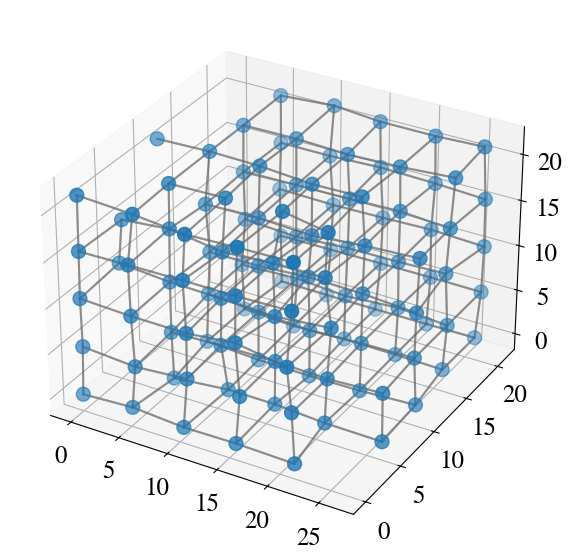

In [19]:
# quick check that generation works
graph = np.load("Data3d/cubic/cubic_P_2003.npz")
print(graph.keys())
print("label: ", graph["label"])
node_values = graph["nodes"]
edge_values = graph["edges"]
adj_list = graph["adj_list"]
pos = graph["positions"]
draw_graph(adj_list, pos, edges=True, save=True, file_name="cubic3d.png")